In [230]:
import pandas as pd
import yfinance as yf
import numpy as np
import plotly.graph_objects as go
import statsmodels.api as sm
from arch import arch_model
import matplotlib.pyplot as plt

sp = yf.download('^GSPC',period='10y', interval='1d')['Close']

#base YTD
sp_ytd = sp.loc['2024-12-31':]

retorno_diario = sp_ytd.pct_change().dropna()
retorno_semanal = sp_ytd.resample('W').last().pct_change().dropna()
retorno_mensal = sp_ytd.resample('M').last().pct_change().dropna()

print(f'Volatilidade YTD, base mensal....{retorno_mensal.std()*np.sqrt(12)}')
print(f'Volatilidade YTD, base semanal....{retorno_semanal.std()*np.sqrt(52)}')
print(f'Volatilidade YTD, base diária...{retorno_diario.std()*np.sqrt(252)}')

[*********************100%***********************]  1 of 1 completed


Volatilidade YTD, base mensal....Ticker
^GSPC    0.129959
dtype: float64
Volatilidade YTD, base semanal....Ticker
^GSPC    0.243432
dtype: float64
Volatilidade YTD, base diária...Ticker
^GSPC    0.292114
dtype: float64


In [233]:

annual_factor = np.sqrt(252) # Fator de anualização

# --- 2. Calcular Retornos  ---
retornos_diarios = sp.pct_change().dropna()

# --- 3. Calcular Volatilidades Anualizadas ---
# Vol 21 dias úteis (Desvio padrão dos retornos diários)
retornos_diarios['Vol21d'] = retornos_diarios.rolling(21).std() * annual_factor

# EWMA 
retornos_diarios['EWMA'] = retornos_diarios['^GSPC'].ewm(span=94, adjust=False).std() * annual_factor

# Grach
am = arch_model(retornos_diarios['^GSPC'], mean='Zero',vol='Garch', p=1, q=1, dist='gaussian')
am_fit = am.fit(disp='off') #[mu,omega, alpha, beta]
retornos_diarios['GARCH'] = am_fit.conditional_volatility * annual_factor

retornos_diarios



c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Ticker,^GSPC,Vol21d,EWMA,GARCH
Date,,,,
2015-04-14,0.001630,NaN,NaN,0.103701
2015-04-15,0.005148,NaN,0.039494,0.097890
2015-04-16,-0.000778,NaN,0.034295,0.099377
2015-04-17,-0.011311,NaN,0.090242,0.093774
2015-04-20,0.009235,NaN,0.090414,0.119985
...,...,...,...,...
2025-04-07,-0.002331,0.313806,0.230295,0.539473
2025-04-08,-0.015701,0.306672,0.229778,0.477923
2025-04-09,0.095154,0.463984,0.319836,0.437899


In [238]:
retornos_diarios.dropna()

Ticker,^GSPC,Vol21d,EWMA,GARCH
Date,,,,
2015-05-12,-0.002950,0.108852,0.087430,0.140751
2015-05-13,-0.000305,0.108732,0.085293,0.130212
2015-05-14,0.010779,0.113675,0.087970,0.119546
2015-05-15,0.000768,0.113608,0.085904,0.134503
2015-05-18,0.003048,0.105520,0.084107,0.123299
...,...,...,...,...
2025-04-07,-0.002331,0.313806,0.230295,0.539473
2025-04-08,-0.015701,0.306672,0.229778,0.477923
2025-04-09,0.095154,0.463984,0.319836,0.437899


<Axes: title={'center': 'Volatilidade Anualizada'}, xlabel='Date'>

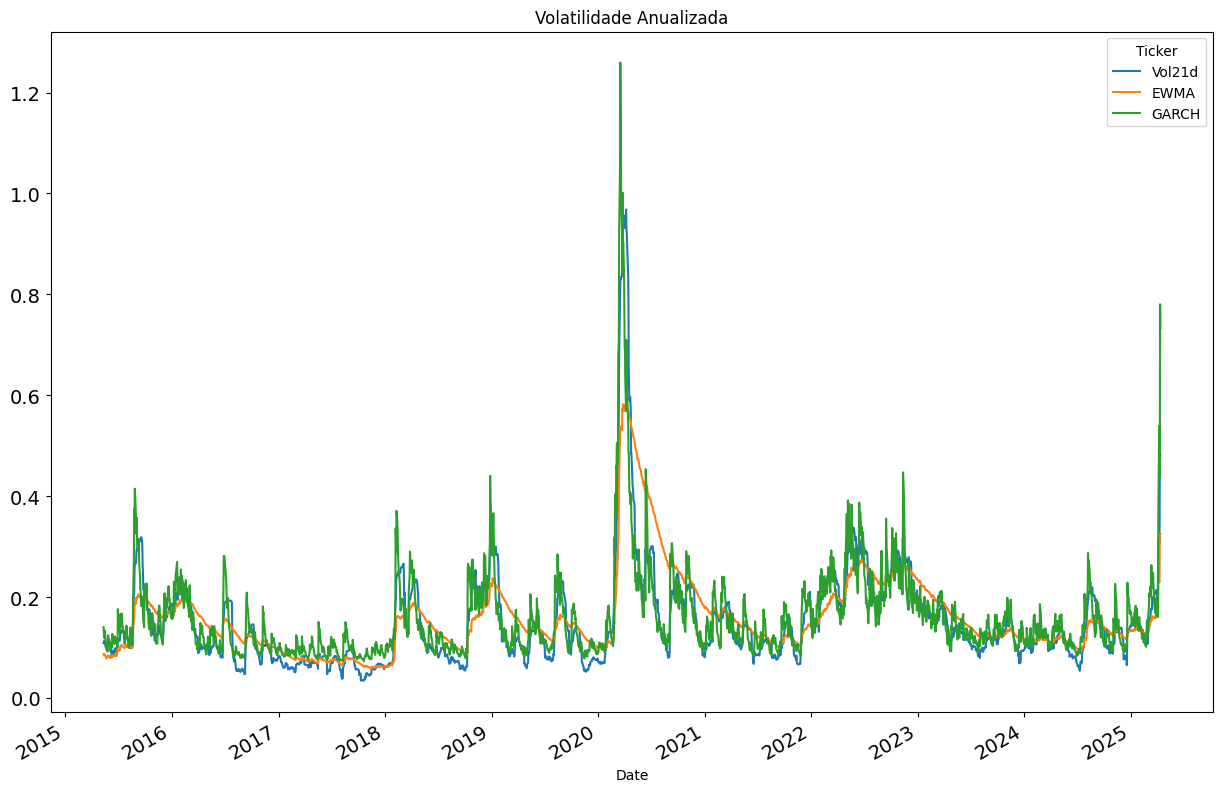

In [235]:
retornos_diarios[['Vol21d', 'EWMA', 'GARCH']].dropna().plot(figsize=(15, 10), title='Volatilidade Anualizada', fontsize=14)

In [228]:
previsao = am_fit.forecast(horizon=183,params=am_fit.params,method='simulation', simulations=120)

(np.sqrt(previsao.variance.iloc[-1]))*np.sqrt(252) # Previsão de volatilidade para 60 dias

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\__future__\_utility.py:11: FutureWarning:


The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.




h.001    0.660746
h.002    0.658659
h.003    0.659057
h.004    0.652761
h.005    0.649901
           ...   
h.179    0.235943
h.180    0.239539
h.181    0.231463
h.182    0.227724
h.183    0.231221
Name: 2025-04-11 00:00:00, Length: 183, dtype: float64

<Axes: title={'center': 'Previsão GARCH'}>

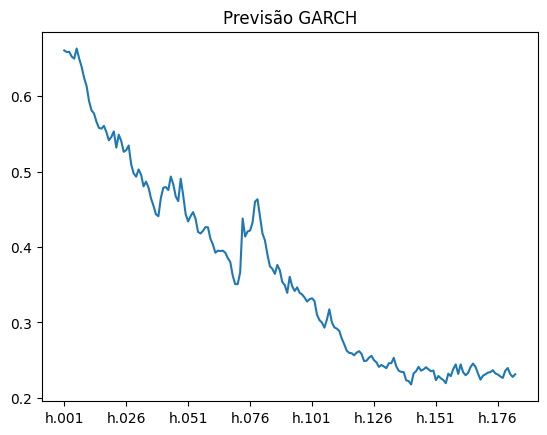

In [239]:
((np.sqrt(previsao.variance.iloc[-1]))*np.sqrt(252)).plot(title='Previsão GARCH') # Previsão de 